<a href="https://colab.research.google.com/github/CarolinRi/CorneaAI/blob/main/Clustering_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install data-science-utils

In [72]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer

from sklearn.decomposition import PCA as sklearnPCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from pandas.plotting import parallel_coordinates

from ds_utils.unsupervised import plot_cluster_cardinality
from ds_utils.unsupervised import plot_cluster_magnitude
from scipy.spatial.distance import euclidean
from scipy import stats
from ds_utils.unsupervised import plot_magnitude_vs_cardinality

from sklearn import metrics
from sklearn.metrics import pairwise_distances

from google.colab import drive

In [73]:
#loading data from github
url = 'https://raw.githubusercontent.com/CarolinRi/CorneaAI/main/Corneae.csv'
data = pd.read_csv(url)

# data.head()
# print(data.columns)

In [74]:
def get_features(feature_count):

  if feature_count == 22:
    # 22 features
    to_keep = ['Sa', 'Sz', 'Str', 'Sdr', 'Sq', 'Ssk', 'Sku', 'Sp', 'Sv', 'Sal','Std','Sdq','Sk', 'Spk', 'Svk', 'Smr1', 'Smr2', 'Sxp', 'Vvv', 'Vvc', 'Vmp', 'Vmc']
    print(f">>> {len(to_keep)} features used: {to_keep}")
  elif feature_count == 21:
    # 21 features: Std eliminated
    to_keep = ['Sa', 'Sz', 'Str', 'Sdr', 'Sq', 'Ssk', 'Sku', 'Sp', 'Sv', 'Sal','Sdq','Sk', 'Spk', 'Svk', 'Smr1', 'Smr2', 'Sxp', 'Vvv', 'Vvc', 'Vmp', 'Vmc']
    print(f">>> {len(to_keep)} features used: {to_keep}")
  elif feature_count == 9:
    # 9 features
    to_keep = ['Str','Sdr','Sq','Ssk','Sku','Sal','Std','Smr1','Smr2']
    print(f">>> {len(to_keep)} features used: {to_keep}")
  elif feature_count == 8:
    # 8 features: Std eliminated
    to_keep = ['Str','Sdr','Sq','Ssk','Sku','Sal','Smr1','Smr2']
    print(f">>> {len(to_keep)} features used: {to_keep}")

  return to_keep


def get_evidence(data, feature_count, export, clear_outliers):

  to_keep = get_features(feature_count)

  assert len(to_keep) == feature_count, f"!!! feature vector containing {len(to_keep)} features instead of {feature_count} features"

  # Dataframe containing the features to be analyzed
  df_evidence = data[to_keep]

  # plot histograms of unscaled data
  df_evidence.hist(bins=15)

  # get labels
  labels = data['name']

  # export to google drive
  if export is True:

    path = '/content/drive/My Drive/evidence_initial.csv'
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      df_evidence.to_csv(f)

  # analyze data composition
  evidence_desc = df_evidence.describe()
  # print(evidence_desc)

  # export to google drive
  if export is True:

    path = '/content/drive/My Drive/description_initial.csv'
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      evidence_desc.to_csv(f)

  # identify and eliminate outliers
  if clear_outliers is True:
    print(">>> outlier removal: on")
    no_outliers = (np.abs(stats.zscore(df_evidence)) < 3).all(axis=1)
    # print(no_outliers.value_counts())

    outliers = [x for x, y in zip(labels.tolist(), no_outliers.to_list()) if y == False]
    print(f">>> removed {len(outliers)} samples: {outliers}")

    df_outliers = pd.DataFrame(outliers)

    # evidence without outliers
    df_evidence = df_evidence[no_outliers]

    # export to google drive
    if export is True:

      path = '/content/drive/My Drive/removed_samples.csv'
      with open(path, 'w', encoding = 'utf-8-sig') as f:
        df_outliers.to_csv(f)

      path = '/content/drive/My Drive/evidence_cleared.csv'
      with open(path, 'w', encoding = 'utf-8-sig') as f:
        df_evidence.to_csv(f)
    
    # labels without outliers
    labels = labels[no_outliers]
  
  labels = labels.values.tolist()

  assert len(labels) == len(df_evidence.axes[0]), f"!!! numer of samples in evidence ({len(df_evidence.axes[0])}) and labels ({len(labels)}) unequal !!!"

  return to_keep, df_evidence, labels

def do_preprocessing(df_evidence, method, export):

  # convert dataframe to numpy
  evidence = df_evidence.values.tolist()

  # scale features
  if method == 'minmax':
    scaler = MinMaxScaler()
  elif method == 'standard':
    scaler = StandardScaler()
  elif method == 'robust':
    scaler = RobustScaler()
  elif method == 'powert':
    scaler = PowerTransformer()
  elif method == 'quantile':
    scaler = QuantileTransformer(output_distribution="normal")
  else:
    print(">>> NO preprocessing conducted")

  evidence = scaler.fit_transform(evidence)

  # convert scaled evidence to DataFrame
  df_evidence_sc = pd.DataFrame(evidence, columns = df_evidence.columns)
  # print(df_evidence_sc)

  #plot histograms of unscaled data
  df_evidence_sc.hist(bins=15)

  # export to google drive
  if export is True:

    path = '/content/drive/My Drive/evidence_scaled.csv'
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      df_evidence_sc.to_csv(f)

    # analyze scaled data composition
    evidence_sc_desc = df_evidence_sc.describe()

    path = '/content/drive/My Drive/description_scaled.csv'
    with open(path, 'w', encoding = 'utf-8-sig') as f:
      evidence_sc_desc.to_csv(f)
  

  return df_evidence_sc



>>> 8 features used: ['Str', 'Sdr', 'Sq', 'Ssk', 'Sku', 'Sal', 'Smr1', 'Smr2']


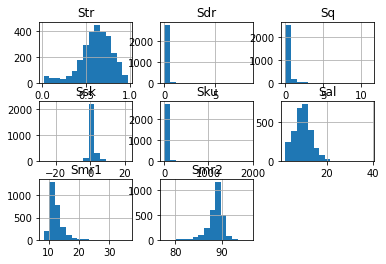

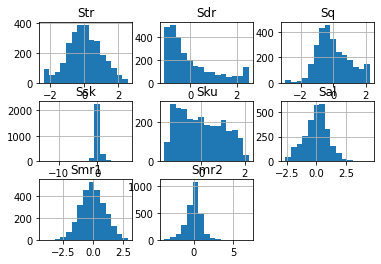

In [137]:
# get evidence as a dataframe and labels as a list; the DF includes the specified set of features
to_keep, df_evidence, labels = get_evidence(data, feature_count = 8, export = True, clear_outliers = False)

# do preprocessing, methods = 'minmax', 'standard', 'robust', 'powert', 'quantile'
df_evidence_sc = do_preprocessing(df_evidence, method = 'powert', export = True)

# print(evidence_sc_desc)


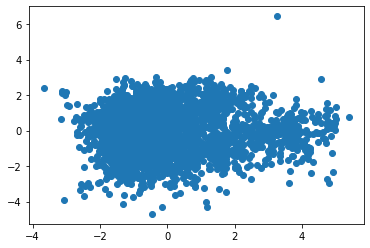

In [138]:
# principal component analysis

pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(df_evidence_sc.copy()))
plt.scatter(transformed[:][0],transformed[:][1])


**1. K means clustering**

- centroid-based

1.1 Elbow method to identify the optimal number of clusters

The number of clusters is varied from 1 to 10 and the WCSS (Within-Cluster Sum of Square) wird berechnet. Die Elbow-shaped Kurve hat einen Punkt, an dem sich die Steigung der Kurven drastisch ändert. Dieser Punkt, der "Ellenbogen", wird als die ideale Anzahl an Clustern gesehen.

1.2 Generate model and plot cluster result in reduced dimensions

1.3 Get evaluation metrics

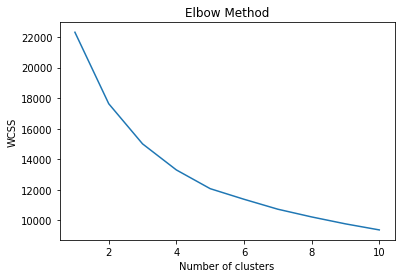

In [139]:
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=None)
    kmeans.fit(df_evidence_sc)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

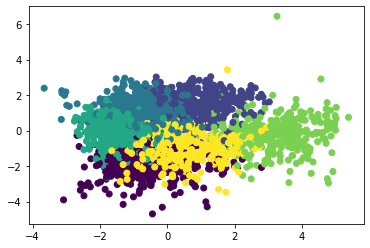

In [152]:
# performing k means clustering with n clusters
kmeans = KMeans(n_clusters=6, init='k-means++', max_iter=300, n_init=10, random_state=None)
pred_y_kmeans = kmeans.fit(df_evidence_sc)

# print(pred_y_kmeans.labels_)

# distances = pred_y_kmeans.transform(evidence)

# print(distances)

# centers = kmeans.cluster_centers_
# transformed_centers = pca.transform(centers)
plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_kmeans.labels_.astype(float))
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=300, c='red')
plt.show()

**1. Cluster cardinality**

Cluster cardinality is the number of examples per cluster

**2. Cluster magnitude**

Cluster magnitude is the sum of distances from all examples to the centroid of the cluster.

**3. Silhouette Coefficient**

high coeff: well defined clusters

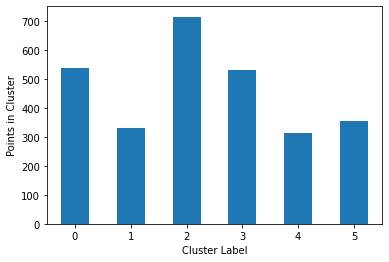

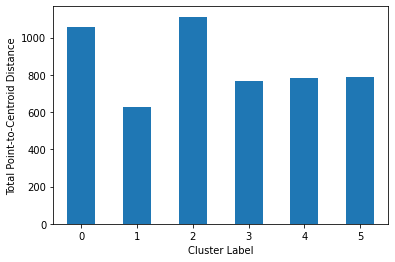

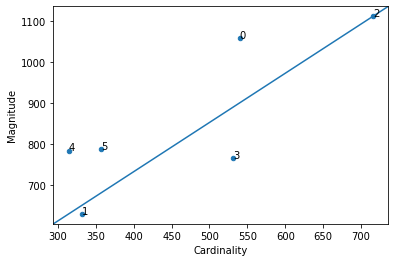

0.1626818079929181 534.9226702683152 1.574504441612584


In [153]:
plot_cluster_cardinality(pred_y_kmeans.labels_)

plot_cluster_magnitude(df_evidence_sc, pred_y_kmeans.labels_, pred_y_kmeans.cluster_centers_,euclidean)

plot_magnitude_vs_cardinality(df_evidence_sc, pred_y_kmeans.labels_, pred_y_kmeans.cluster_centers_, euclidean)

plt.show()

# metrics.silhouette_score(evidence, pred_y.labels_, metric='euclidean')

Sil_kmeans = metrics.silhouette_score(df_evidence_sc, pred_y_kmeans.labels_, metric='euclidean')
CH_kmeans = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_kmeans.labels_)
DB_kmeans = metrics.davies_bouldin_score(df_evidence_sc, pred_y_kmeans.labels_)

print(Sil_kmeans, CH_kmeans, DB_kmeans)

**Export the mean value and std of each feature grouped by clusters**



In [151]:
export_1 = True

data_forplot = df_evidence.copy()

data_forplot['labels'] = pred_y_kmeans.labels_

# print(data_forplot)

data_bylabel = data_forplot.groupby(by='labels')

avg_vals = data_bylabel.mean()
std_vals = data_bylabel.std()

print(avg_vals)
print(std_vals)

if export_1 is True:

  from google.colab import drive

  drive.mount('/content/drive')
  path = '/content/drive/My Drive/mean_vals.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    avg_vals.to_csv(f)

    path = '/content/drive/My Drive/std_vals.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    std_vals.to_csv(f)



             Str       Sdr        Sq       Ssk        Sku        Sal  \
labels                                                                 
0       0.605607  0.005068  0.193349  0.274229   7.264998  10.644068   
1       0.761829  0.021779  0.365751  0.858089  18.617900  12.874767   
2       0.523392  0.274990  1.531443 -0.665219  45.225476  12.113141   
3       0.533089  0.042989  0.326858  0.319717   6.167679   5.482674   
4       0.659814  0.010747  0.247179  3.995263  73.056609   9.947971   

             Smr1       Smr2  
labels                        
0       10.978959  88.921538  
1       13.963776  89.976836  
2       15.875865  86.059904  
3       12.122919  88.940643  
4       11.853193  88.645856  
             Str       Sdr        Sq       Ssk         Sku       Sal  \
labels                                                                 
0       0.150497  0.004335  0.069355  0.445726    4.364903  2.777280   
1       0.121196  0.023263  0.197072  1.334059   34.052716  5.

**Export a sorted list of samples closest to each clusters centroid**

In [50]:
export_2 = True

sorting_result = {}

for i in range(0,len(pred_y_kmeans.cluster_centers_)):

  distances = kmeans.transform(df_evidence_sc)[:,i]

  # print(list(zip(distances, data['name'])))

  # new_dist, new_labels = zip(*sorted(zip(distances, data['name'])))

  new_dist, new_labels = (list(t) for t in zip(*sorted(zip(distances, data['name']))))

  print(new_dist)
  print(new_labels)

  sorting_result[f'distances cluster {i+1}'] = new_dist
  sorting_result[f'names {i+1}'] = new_labels


# ind = np.argsort(d)[::-1][:50]

if export_2 is True:

  from google.colab import drive

  dataframe = pd.DataFrame.from_dict(sorting_result)

  drive.mount('/content/drive')
  path = '/content/drive/My Drive/output.csv'
  with open(path, 'w', encoding = 'utf-8-sig') as f:
    dataframe.to_csv(f)


[0.04193651728120823, 0.058758759637505556, 0.06162873394739356, 0.06802702026863469, 0.06992957282169011, 0.0716837503165367, 0.07612932196921007, 0.07723348125920412, 0.07739135514095342, 0.07917443096732034, 0.08064685401622156, 0.08149483222333746, 0.08351280633367533, 0.08578502252565177, 0.08772771282373525, 0.09337018434719425, 0.09337789858962647, 0.09562967242608288, 0.09650390477733789, 0.09672657158399336, 0.09777884862507695, 0.09899913757463889, 0.09954402529052364, 0.10026351700674194, 0.10245491683985784, 0.10420126105482115, 0.10453615753759286, 0.10524338914981261, 0.10634743878659397, 0.10725745239670571, 0.10833073013886829, 0.10925985773009028, 0.11054204170861154, 0.11194821608555755, 0.11246411760653038, 0.11283339986394679, 0.11300639133768496, 0.11553179626893792, 0.11637091130120267, 0.11652478493697317, 0.11921854334227536, 0.12008203877247095, 0.12200188894984454, 0.12276082361964825, 0.12435714021880924, 0.1247703572917928, 0.12503875110435755, 0.12735574286

**2. Mean-shift clustering**



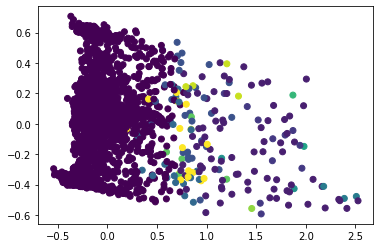

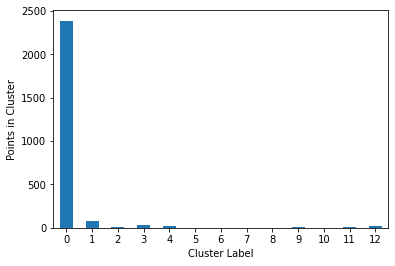

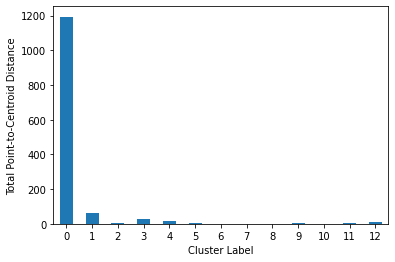

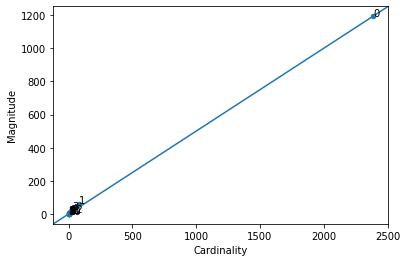

0.37331964822814406 91.26591225776575 1.4260500320267404


In [26]:
from sklearn.cluster import MeanShift

meanshift = MeanShift()

pred_y_meanshift = meanshift.fit(df_evidence_sc)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_meanshift.labels_.astype(float))

plt.show()

plot_cluster_cardinality(pred_y_meanshift.labels_)

plot_cluster_magnitude(df_evidence_sc, pred_y_meanshift.labels_, pred_y_meanshift.cluster_centers_,euclidean)

plot_magnitude_vs_cardinality(df_evidence_sc, pred_y_meanshift.labels_, pred_y_meanshift.cluster_centers_, euclidean)

plt.show()

Sil_meanshift = metrics.silhouette_score(df_evidence_sc, pred_y_meanshift.labels_, metric='euclidean')
CH_meanshift = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_meanshift.labels_)
DB_meanshift = metrics.davies_bouldin_score(df_evidence_sc, pred_y_meanshift.labels_)

print(Sil_meanshift, CH_meanshift, DB_meanshift)

**3. Spectral clustering**

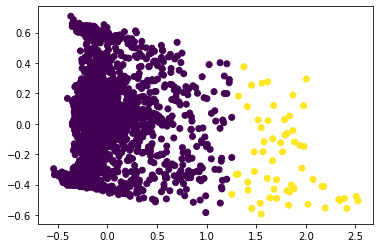

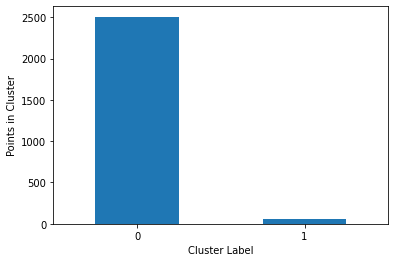

0.6095029827302524 570.197705365588 0.6820305848058325


In [27]:
from sklearn.cluster import SpectralClustering

spectral = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=None)

pred_y_spectral = spectral.fit(df_evidence_sc)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_spectral.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_spectral.labels_)

plt.show()

Sil_spectral = metrics.silhouette_score(df_evidence_sc, pred_y_spectral.labels_, metric='euclidean')
CH_spectral = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_spectral.labels_)
DB_spectral = metrics.davies_bouldin_score(df_evidence_sc, pred_y_spectral.labels_)

print(Sil_spectral, CH_spectral, DB_spectral)

**4. Agglomerative clustering**

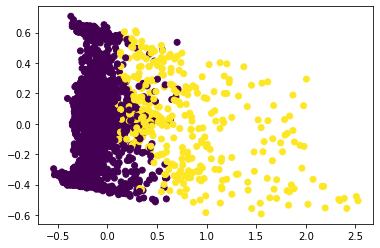

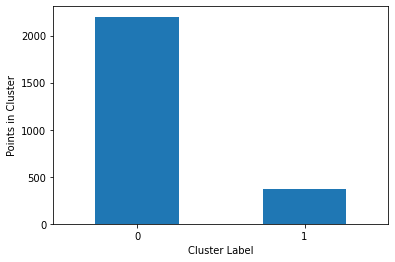

0.3864421197697597 769.2445693835483 1.4115345228472527


In [28]:
from sklearn.cluster import AgglomerativeClustering

agglom = AgglomerativeClustering()
pred_y_agglom = agglom.fit(df_evidence_sc)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_agglom.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_agglom.labels_)

plt.show()

Sil_agglom = metrics.silhouette_score(df_evidence_sc, pred_y_agglom.labels_, metric='euclidean')
CH_agglom = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_agglom.labels_)
DB_agglom = metrics.davies_bouldin_score(df_evidence_sc, pred_y_agglom.labels_)

print(Sil_agglom, CH_agglom, DB_agglom)

**5. Gaussian mixture**

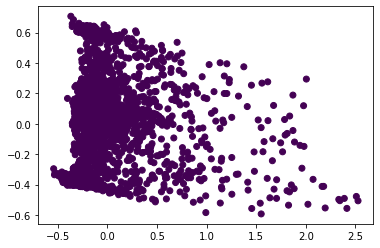

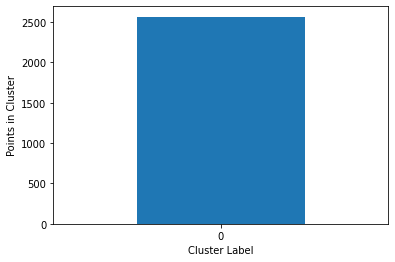

ValueError: ignored

In [30]:
from sklearn.cluster import OPTICS

optics_m = OPTICS(min_samples=1)
pred_y_optics = optics_m.fit(df_evidence_sc)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_optics.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_optics.labels_)

plt.show()

Sil_optics = metrics.silhouette_score(df_evidence_sc, pred_y_optics.labels_, metric='euclidean')
CH_optics = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_optics.labels_)
DB_optics = metrics.davies_bouldin_score(df_evidence_sc, pred_y_optics.labels_)

print(Sil_optics, CH_optics, DB_optics)


**6. BIRCH**

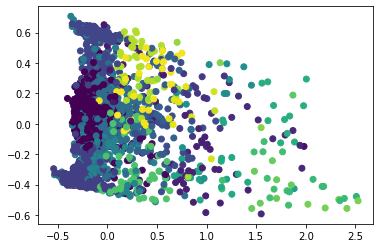

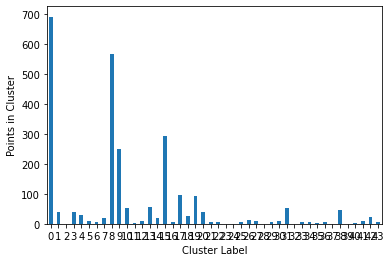

0.20426213231858784 155.72406733951698 1.297550342115257


In [31]:
from sklearn.cluster import Birch

brc = Birch(n_clusters=None)
pred_y_brc = brc.fit(df_evidence_sc)

plt.scatter(transformed[:][0],transformed[:][1],c=pred_y_brc.labels_.astype(float))
plt.show()

plot_cluster_cardinality(pred_y_brc.labels_)

plt.show()

Sil_brc = metrics.silhouette_score(df_evidence_sc, pred_y_brc.labels_, metric='euclidean')
CH_brc = metrics.calinski_harabasz_score(df_evidence_sc, pred_y_brc.labels_)
DB_brc = metrics.davies_bouldin_score(df_evidence_sc, pred_y_brc.labels_)

print(Sil_brc, CH_brc, DB_brc)